In [1]:
import os 
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## 1. Load Data

In [2]:
# read data - data downloaded on https://grouplens.org/datasets/movielens/latest/
df_movies = pd.read_csv(
    './ml-latest/movies.csv',
    usecols=['movieId', 'title'],
    dtype={'movieId': 'int32', 'title': 'str'})

df_ratings = pd.read_csv(
    './ml-latest/ratings.csv',
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [3]:
df_movies.head()
df_movies.shape

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


(58098, 2)

In [4]:
df_ratings.head()
df_ratings.shape

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


(27753444, 3)

## Exploratory analysis

In [5]:
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
num_ratings = df_ratings.shape[0]
print('There are {} unique users and {} unique movies in this data set with {} different ratings'.format(num_users, num_items, num_ratings))

There are 283228 unique users and 53889 unique movies in this data set with 27753444 different ratings


In [6]:
num_movies = df_movies.nunique()[1]
shape_movies = df_movies.shape
print('There are {} unique movies in a dataset with the following shape: {}'.format(num_movies, shape_movies))

There are 58020 unique movies in a dataset with the following shape: (58098, 2)


### Rating group by

In [7]:
count_ratings = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]
# append counts of zero rating to count_ratings
count_ratings = count_ratings.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
count_ratings

,count
0.0,15235120248
0.5,442388
1.0,886233
1.5,441354
2.0,1850627
2.5,1373419
3.0,5515668
3.5,3404360
4.0,7394710
4.5,2373550


Text(0.5, 0, 'movie rating score')

Text(0, 0.5, 'number of ratings')

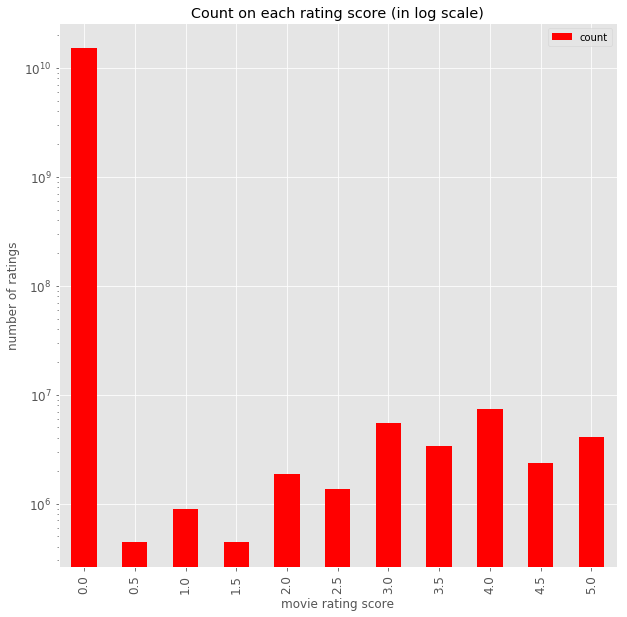

In [8]:
ax = count_ratings[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(10, 10),
    title='Count on each rating score (in log scale)',
    logy=True,
    fontsize=12,
    color = 'red'
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

### Movie groupby

In [9]:
rating_movies_count = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])

Text(0.5, 0, 'movieID')

Text(0, 0.5, 'number of ratings')

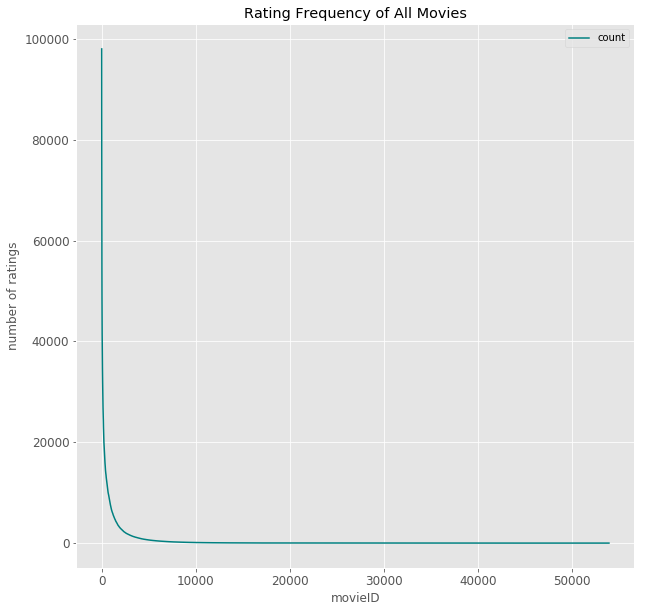

In [10]:
ax = rating_movies_count \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(10, 10),
        title='Rating Frequency of All Movies',
        fontsize=12,
        color = 'teal'
    )
ax.set_xlabel("movieID")
ax.set_ylabel("number of ratings")

In [11]:
rating_movies_count['count'].quantile(np.arange(1,0.6,-0.05))

1.00    97999.0
0.95     1855.0
0.90      531.0
0.85      205.0
0.80       91.0
0.75       48.0
0.70       28.0
0.65       18.0
Name: count, dtype: float64

In [12]:
##filter data##
popularity_thres = 50
popular_movies = list(set((rating_movies_count[rating_movies_count['count']>=popularity_thres]).index))
rating_movies_filtered = df_ratings[(df_ratings['movieId'].isin(popular_movies))]
print('shape of original data: ' ,  df_ratings.shape)
print('shape of final data after drop: ', rating_movies_filtered.shape)

shape of original data:  (27753444, 3)
shape of final data after drop:  (27430748, 3)


#### user count

In [13]:
df_users_cnt = pd.DataFrame(rating_movies_filtered.groupby('userId').size(), columns=['count'])

Text(0.5, 0, 'user Id')

Text(0, 0.5, 'number of ratings')

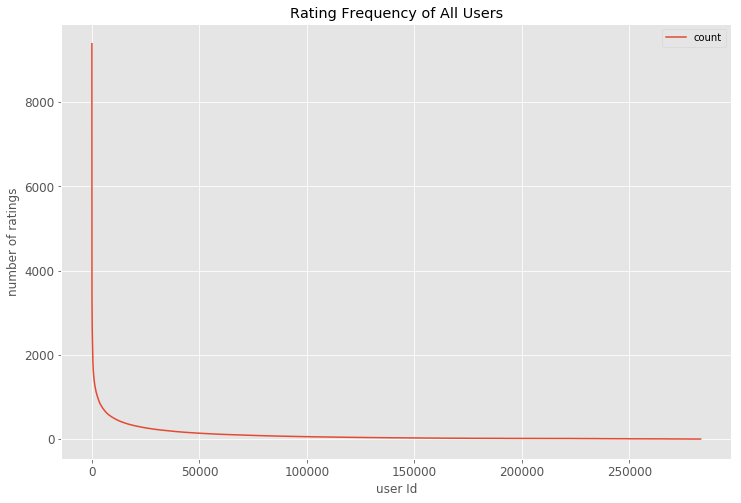

In [14]:
# plot rating frequency of all movies
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings")

In [15]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    9384.0
0.95     403.0
0.90     239.0
0.85     164.0
0.80     121.0
0.75      94.0
0.70      73.0
0.65      58.0
0.60      47.0
0.55      37.0
Name: count, dtype: float64

In [16]:
# filter data
ratings_thres = 50
active_users = list(set((df_users_cnt[df_users_cnt['count']>=ratings_thres]).index))
df_ratings_drop_users = rating_movies_filtered[rating_movies_filtered['userId'].isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (27753444, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (24178982, 3)


## Train KNN model for collaborative filtering

In [17]:
df_ratings_drop_users.head()

,userId,movieId,rating
42,4,1,4.0
43,4,2,4.0
44,4,5,2.0
45,4,6,4.5
46,4,10,4.0


In [18]:
from scipy.sparse import csr_matrix

In [19]:
# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index= 'movieId', columns= 'userId', values = 'rating').fillna(0)
#create mapper from movie tittle to index
movie_to_idx= {}
for i, movie in enumerate(df_movies.set_index('movieId').loc[movie_user_mat.index].title):
    movie_to_idx[movie]=i
# transform matrix to scipy sparse matrix
movie_user_mat_spar = csr_matrix(movie_user_mat.values)

### Fitting model

In [67]:
from sklearn.neighbors import NearestNeighbors
#Define
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
#Fit
model_knn.fit(movie_user_mat_spar)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=-1, n_neighbors=20, p=2, radius=1.0)

### Recomemndation system

In [68]:
# utils import
from fuzzywuzzy import fuzz

In [69]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]


In [70]:
def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [107]:
my_favorite = 'Batman'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_spar,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Batman
Found possible matches in our database: ['Batman (1966)', 'Batman (1989)']

Recommendation system start to make inference
......

Recommendations for Batman:
1: You Only Live Twice (1967), with distance of 0.8330495357513428
2: Batman & Robin (1997), with distance of 0.831415057182312
3: Superman Returns (2006), with distance of 0.8283013105392456
4: Batman: Mask of the Phantasm (1993), with distance of 0.8267700672149658
5: Twilight Zone: The Movie (1983), with distance of 0.8227242231369019
6: Octopussy (1983), with distance of 0.8213573098182678
7: Dragnet (1987), with distance of 0.8201932907104492
8: Batman Returns (1992), with distance of 0.8078951835632324
9: High Anxiety (1977), with distance of 0.8052446842193604
10: Darkman (1990), with distance of 0.8002312779426575


In [97]:
# calcuate total number of entries in the movie-user matrix
num_entries = movie_user_mat.shape[0] * movie_user_mat.shape[1]
# calculate total number of entries with zero values
num_zeros = (movie_user_mat==0).sum(axis=1).sum()
# calculate ratio of number of zeros to number of entries
ratio_zeros = num_zeros / num_entries
print('There is about {:.2%} of ratings in our data is missing'.format(ratio_zeros))

There is about 98.35% of ratings in our data is missing
